In [1]:
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
import cv2
import os
from src.features.build_features import getLBPimage, create_lbp_by_rings
from src.models.train_model import multiple_cls_test, preprocess_data

__file__ = os.path.abspath('')

project_dir = Path(__file__).resolve()


In [2]:
image_path = '../data/raw/220413/tiff/reflection'
verfiy_image = image_path + '/dark_blue/220413A_X0p7_RWhite.tiff'

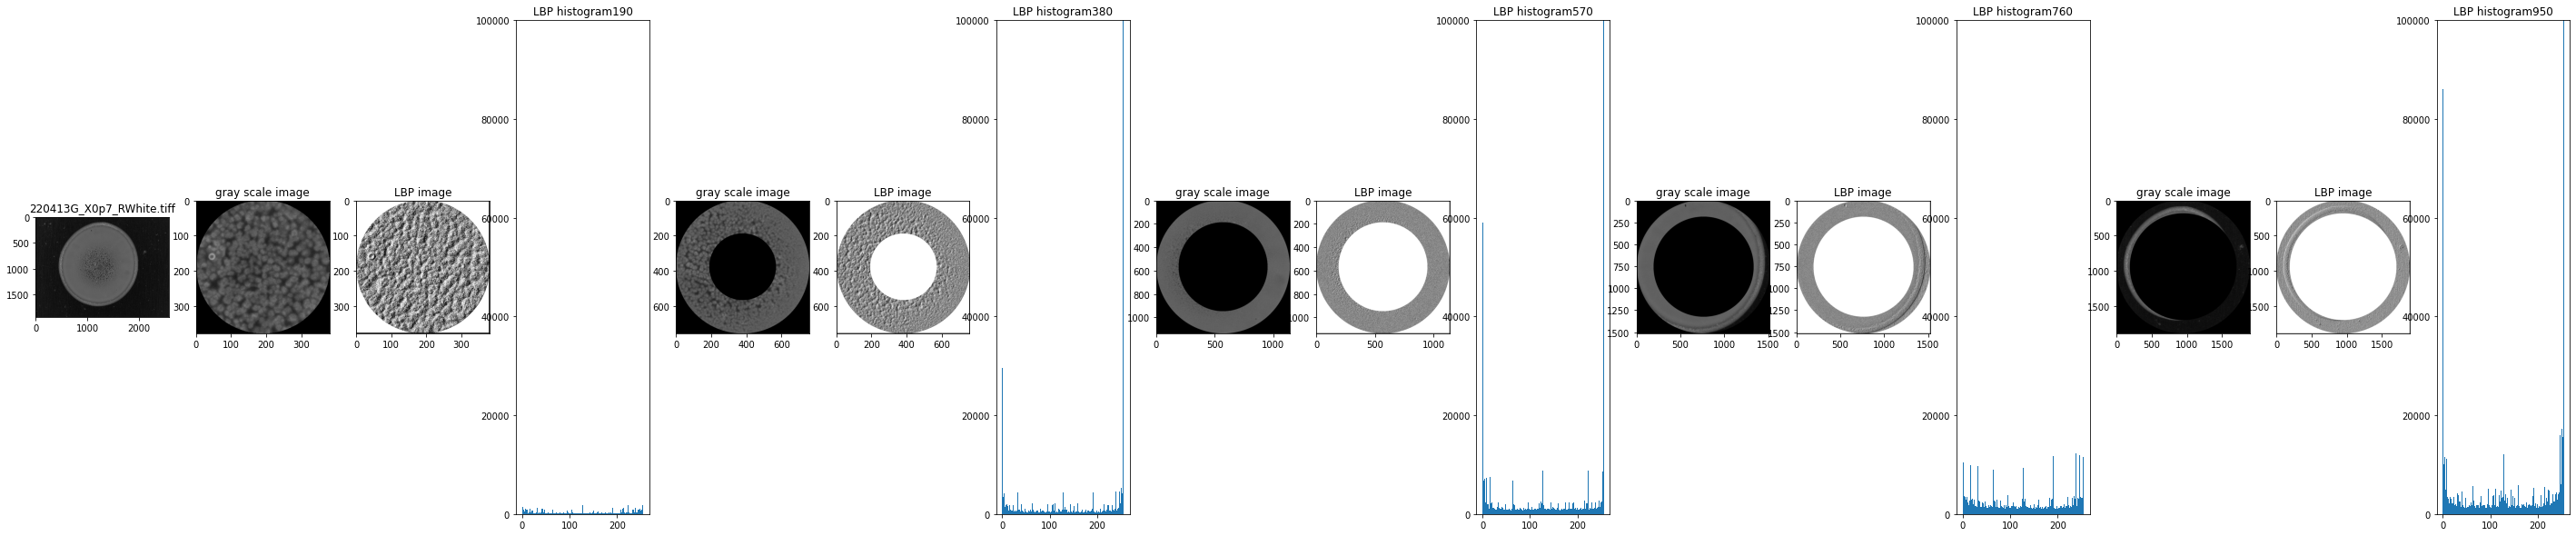

In [3]:
dark_blue = Path(str(image_path) + '/dark_blue').resolve()

db_data, db_labels = create_lbp_by_rings(dark_blue)

In [4]:
db_data[0][0].flatten().shape

(144400,)

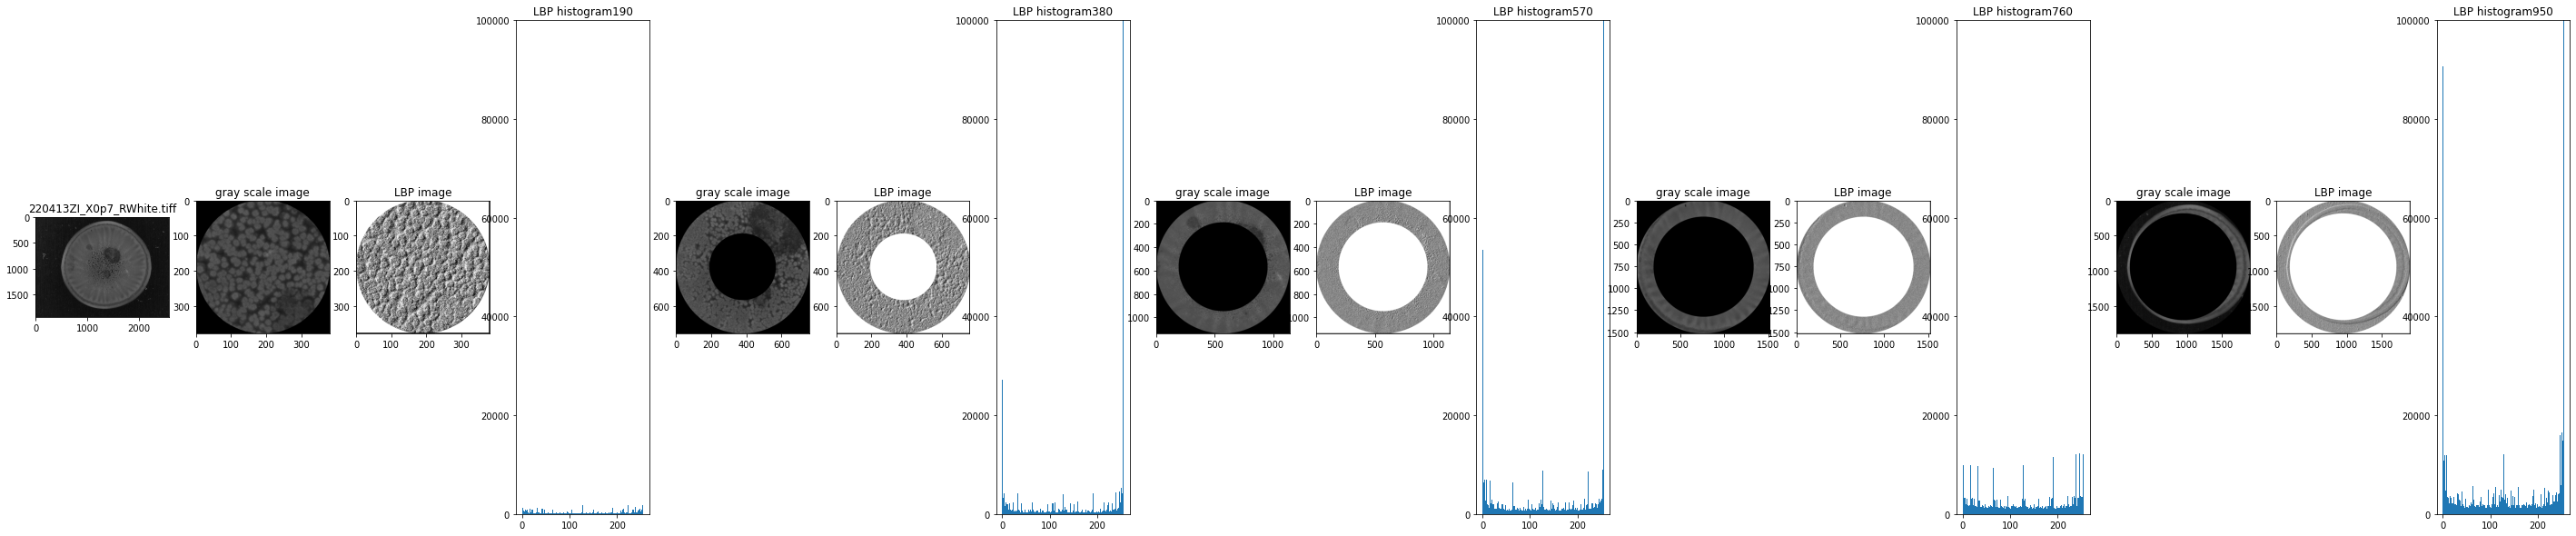

In [5]:
dbm_path = Path(str(image_path) + '/dbm_gm').resolve()

dbm_data, dbm_labels = create_lbp_by_rings(dbm_path)

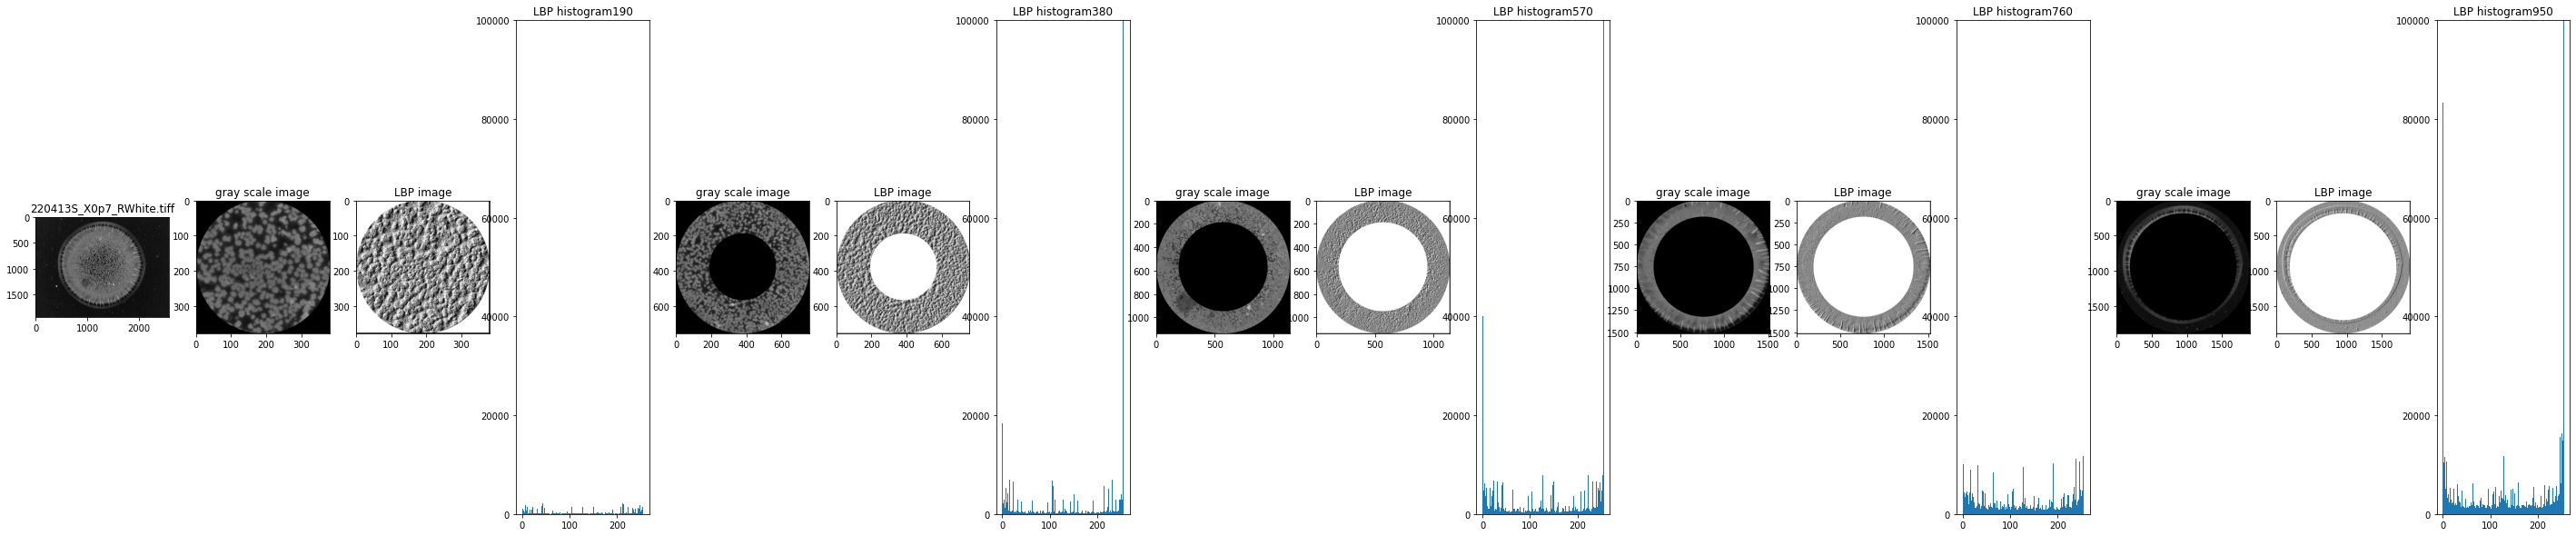

In [6]:
green_trim = Path(str(image_path) + '/green_trim').resolve()
gt_data, gt_labels =create_lbp_by_rings(green_trim)

In [9]:
all_vector_data = []
for i in range(5):
    all_vector_data.append(db_data[i] + dbm_data[i] + gt_data[i])
all_labels = db_labels + dbm_labels + gt_labels

In [10]:
def train_test_cls(trainX, testX, trainY, testY, classifier, le):
    model = classifier #KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    model.fit(trainX, trainY)
    return round(model.score(testX, testY),2)

In [24]:
from src.models.train_model import preprocess_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

def measure_performance(data, labels):
    result_ac = []
    trainX, testX, trainY, testY, le = preprocess_data(data, labels)
#     print(len(trainX[0]), len(testX))
#     print(trainY, testY)
    cls = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
    
    results = train_test_cls(trainX, testX, trainY, testY, cls, le)
#     print('The results of KNeighborsClassifier:')
#     print(results)
    result_ac.append(results)

    cls = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
    results = train_test_cls(trainX, testX, trainY, testY, cls, le)
#     print('The results of GradientBoostingClassifier:')
#     print(results)
    result_ac.append(results)

    cls = DecisionTreeClassifier(random_state=0)
    results = train_test_cls(trainX, testX, trainY, testY, cls, le)
#     print('The results of DecisionTreeClassifier:')
#     print(results)
    result_ac.append(results)
    return result_ac

result_acs = []
for i in range(5):
#     print('The ', i, ' th circle:')
    data, labels = all_vector_data[i],  all_labels
    result_acs.append(measure_performance(data, labels))

[[0.44, 0.33, 0.33],
 [0.44, 0.22, 0.22],
 [0.44, 0.0, 0.22],
 [0.44, 0.22, 0.44],
 [0.11, 0.11, 0.22]]

In [25]:

merged_vectors = []
for j in range(len(all_vector_data[0])):
    merged_vector = np.concatenate(([all_vector_data[i][j].flatten() for i in range(4)]), -1)
    merged_vectors.append(merged_vector)
#     data, labels = all_vector_data[i],  all_labels
result_acs.append(measure_performance(merged_vectors, labels))

In [26]:
result_acs

[[0.44, 0.33, 0.33],
 [0.44, 0.22, 0.22],
 [0.44, 0.0, 0.22],
 [0.44, 0.22, 0.44],
 [0.11, 0.11, 0.22],
 [0.44, 0.22, 0.22]]

In [30]:
import pandas as pd
df = pd.DataFrame(result_acs, columns=['KNN', 'GradientBoost', 'Decision Tree'], 
                  index=['Ring 1', 'Ring 2', 'Ring 3', 'Ring 4', 'Ring 5', 'Merged 1,2,3,4'])
print('The accuracy of different classifiers using the data from distinguished rings and merged rings')
df

The accuracy of different classifiers using the data from distinguished rings and merged rings


,KNN,GradientBoost,Decision Tree
Ring 1,0.44,0.33,0.33
Ring 2,0.44,0.22,0.22
Ring 3,0.44,0.00,0.22
Ring 4,0.44,0.22,0.44
Ring 5,0.11,0.11,0.22
"Merged 1,2,3,4",0.44,0.22,0.22
